In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as si
import sympy as sy
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
from scipy.stats.mstats import gmean

In [11]:

def montecarlo_simulation_asian_geometric(N, sim,S=100, sigma=0.2, r=0.06, T=1, K=99, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / N
    
    prices = np.zeros(shape=(sim, N+1))
    prices[:, 0] = S
    
    for i in range(1, N+1):
        eps = np.random.normal(size=(sim))
        prices[:, i] = prices[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * eps)

    prices = prices[:, 1:]
    
    payoffs = gmean(prices, axis=1) - K
    payoffs[payoffs < 0] = 0
    
    price = math.exp(-r * T) * payoffs.mean()
    std_error = np.std(payoffs) / math.sqrt(sim)
    
    return price

In [15]:
Aisan_mean_1=[]
Aisan_std_1=[]
for i in np.arange(100,10000,100):
    price=[montecarlo_simulation_asian_geometric(N=500,sim=i) for h in range (10)]
    Aisan_mean_1.append(np.mean(price))
    Aisan_std_1.append(np.std(price))

KeyboardInterrupt: 

In [18]:
len(np.arange(100,10000,100))

99

In [143]:
plt.rcParams['figure.figsize'] = (7, 5) 
plt.style.use("seaborn-darkgrid")
k=99.
s_0=100.
r=0.06
t=1.
sigma=0.2
decision = 0 #call option

In [215]:
import numpy as np
from scipy.stats import norm
# this is just a simple, straightforward implementation from the formulas
def black_scholes(K, St, t=0, r=0.06, volatility=0.2, T=1):
    d1 = 1 / (volatility * np.sqrt(T - t)) * (np.log(St / K) + (r + (volatility**2) / 2)*(T - t))
    d2 = d1 - volatility * np.sqrt(T - t)
    return norm.cdf(d1)*St - norm.cdf(d2)*K*np.exp(-r*(T - t)), norm.cdf(d1)

In [216]:
black_scholes(99, 100)

(11.544280227051097, 0.6737355117348961)

In [1]:
def bintree(K, S0, r=0.06, volatility=0.2, N=50, T=1, european=True, call=True):
    # we create delta t equal subintervals, calculate delta
    delta = T / N
    
    # we need to calculate u once
    u = np.exp(volatility * np.sqrt(delta))
    d = 1 / u
    
    # 'tree' where we store all nodes
    f = {}
    
    # first, we construct the known values at time T, because we can easily calculate those
    for j in range(N + 1):
        # calculate amount of times up, (down will be negative, but that does not matter since u = 1/d)
        up = N - 2 * j

        # calculate u and Sij, and store the result
        Si = S0 * (u ** up)

        # nodes should be from the bottom up (higher j is higher stock)
        # so we reverse that here
        f[(N, N - j)] = max(0, Si - K if call else K - Si)
        
    # calculate the discount term
    discount = np.exp(-r*delta)
    
    # calculate p
    p = (np.exp(r * delta) - d) / (u - d) 

    # iterate over all nodes in this step
    for i in reversed(range(N)):
        for j in range(i + 1):
            # calculate the value, and discount it
            f[(i, j)] = discount * (p * f[(i+1,j+1)] + (1 - p)*f[(i+1, j)])
            
            # if the option is american, we need to do an extra calculation, because it may
            # also be exercised right now
            if european: 
                continue
                
            # calculate amount of times up, (down will be negative, but that does not matter since u = 1/d)
            down = i - 2*j

            # calculate u and Sij, and store the result
            Si = S0 * (d ** down)
            
            # choose the maximum value between exercising right now or waiting
            f[(i, j)] = max(f[(i, j)], Si - K if call else K - Si)
            
    # calculate the hedge parameter
    hedge = (f[(1, 1)] - f[(1, 0)]) / (S0 * (u - d))
        
    # we are done, return the full tree
    return f[0,0], hedge, f

In [19]:
value, hedge, tree = bintree(99, 100, N=5, volatility=0.2)
value, hedge

(11.87716117252018, 0.6594893541702542)

In [3]:
value, hedge, tree = bintree(99, 100, N=50, volatility=0.2, call=False)
value, hedge

(4.78112367559588, -0.32744303539522224)

In [21]:
value, hedge, tree = bintree(99, 100, N=5, volatility=0.2, european=False)
value, hedge

(11.87716117252018, 0.6594893541702542)

In [22]:
value, hedge, tree = bintree(99, 100, N=5, volatility=0.2, european=False, call=False)
value, hedge

(5.607876892029017, -0.3889504407890788)

# Comparison of Binary Tree vs Black-Scholes over Volatility

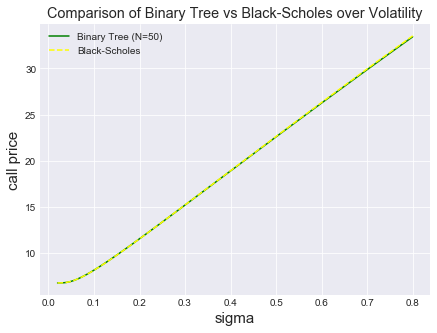

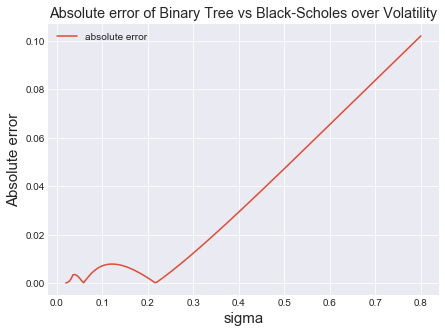

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(7,5))
# evaluate both models (bintree is very slow in comparison)
volatilities = np.linspace(0.02, 0.8, 200)
bt = np.array([bintree(99, 100, N=50, volatility=v)[0] for v in volatilities])
bs = np.array([black_scholes(99, 100, volatility=v)[0] for v in volatilities])

# plot versus the volatilities
plt.plot(volatilities, bt, label='Binary Tree (N=50)',color='green')
plt.plot(volatilities, bs,'--', label='Black-Scholes',color='yellow')

plt.title('Comparison of Binary Tree vs Black-Scholes over Volatility')
plt.xlabel('sigma',size=15)
plt.ylabel('call price',size=15)
plt.legend()
plt.savefig('Comparison of Binary Tree vs Black-Scholes over Volatility.jpg',dpi=200)
plt.show()
plt.figure(figsize=(7,5))
plt.plot(volatilities,abs(bt-bs),label='absolute error')
plt.title('Absolute error of Binary Tree vs Black-Scholes over Volatility')
plt.xlabel('sigma',size=15)
plt.ylabel('Absolute error',size=15)
plt.legend()
plt.savefig('Absolute error of Binary Tree vs Black-Scholes over Volatility.jpg',dpi=200)

# convergence+complexity

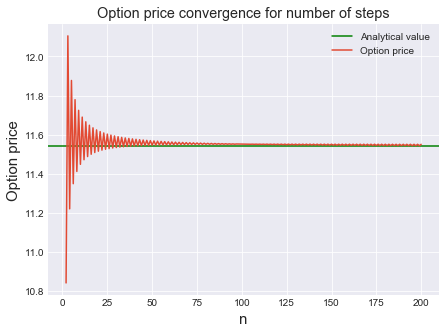

In [231]:
plt.figure(figsize=(7,5))
steplist=np.arange(200,1,-1)
bt_co = np.array([bintree(99, 100, N=n, volatility=0.2)[0] for n in steplist])
plt.axhline(y=11.544280227051097, color='g', linestyle='-',label='Analytical value')
plt.plot(steplist, bt_co, label='Option price')
plt.title('Option price convergence for number of steps')
plt.xlabel('n',size=15)
plt.ylabel('Option price',size=15)
plt.legend()
plt.savefig('Option price convergence for number of steps.jpg',dpi=200)

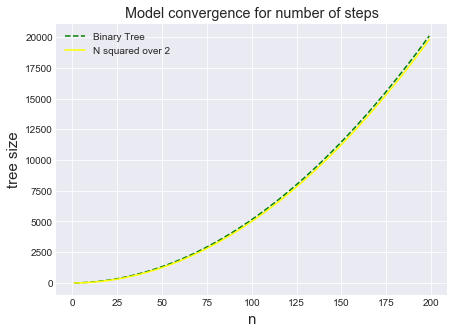

In [219]:
# evaluate both models (bintree is very slow in comparison)
plt.figure(figsize=(7,5))
n = np.arange(1, 200)
tree_size = np.array([len(bintree(99, 100, N=steps)[2]) for steps in n])
n_squared = n * n / 2

# plot versus the volatilities
plt.plot(n, tree_size,'--',label='Binary Tree',color='green')
plt.plot(n, n_squared, label='N squared over 2',color='yellow')
plt.title('Model convergence for number of steps')
plt.xlabel('n',size=15)
plt.ylabel('tree size',size=15)
plt.legend(loc=2)
plt.savefig('Model convergence for number of steps.jpg',dpi=200)
# the reason it is n squared over two is that on average, it is only 
# multiplied by half (because not every timestep has every node). however,
# this still boils down to O(n^2)

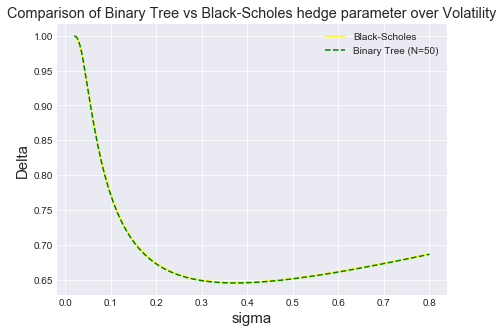

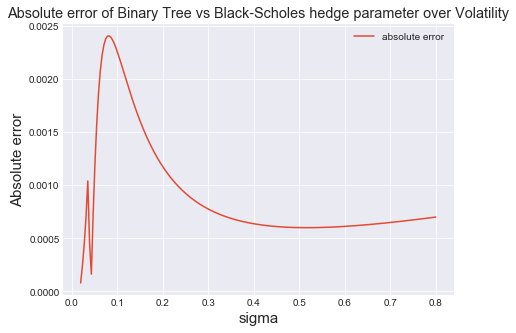

In [174]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(7,5))
# evaluate both models (bintree is very slow in comparison)
volatilities = np.linspace(0.02, 0.8, 200)
bt = np.array([bintree(99, 100, N=50, volatility=v)[1] for v in volatilities])
bs = np.array([black_scholes(99, 100, volatility=v)[1] for v in volatilities])

# plot versus the volatilities

plt.plot(volatilities, bs, label='Black-Scholes',color='yellow')
plt.plot(volatilities, bt, '--',label='Binary Tree (N=50)',color='green')
plt.title('Comparison of Binary Tree vs Black-Scholes hedge parameter over Volatility')
plt.xlabel('sigma',size=15)
plt.ylabel('Delta',size=15)
plt.legend()
plt.savefig('Comparison of Binary Tree vs Black-Scholes hedge parameter over Volatility.jpg',dpi=200)

plt.figure(figsize=(7,5))
plt.plot(volatilities,abs(bt-bs),label='absolute error')
plt.title('Absolute error of Binary Tree vs Black-Scholes hedge parameter over Volatility')
plt.xlabel('sigma',size=15)
plt.ylabel('Absolute error',size=15)
plt.legend()
plt.savefig('Absolute error of Binary Tree vs Black-Scholes hedge parameter over Volatility.jpg',dpi=200)

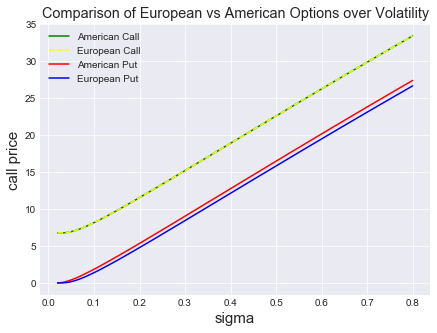

In [192]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(7,5))
# evaluate both models (bintree is very slow in comparison)
volatilities = np.linspace(0.02, 0.8, 200)
american_c = np.array([bintree(99, 100, N=50, volatility=v, european=False)[0] for v in volatilities])
european_c = np.array([bintree(99, 100, N=50, volatility=v)[0] for v in volatilities])
american_p = np.array([bintree(99, 100, N=50, volatility=v, european=False, call=False)[0] for v in volatilities])
european_p = np.array([bintree(99, 100, N=50, volatility=v, call=False)[0] for v in volatilities])

# plot versus the volatilities
plt.plot(volatilities, american_c, label='American Call',color='green')
plt.plot(volatilities, european_c,'--',label='European Call',color='yellow')
plt.plot(volatilities, american_p, label='American Put',color='red')
plt.plot(volatilities, european_p, label='European Put',color='blue')
plt.title('Comparison of European vs American Options over Volatility')
plt.xlabel('sigma',size=15)
plt.ylabel('call price',size=15)
plt.legend()
plt.savefig('Comparison of European vs American Options over Volatility.jpg',dpi=200)

# Part two

In [347]:
def black(S, K, t, r, sigma, T=1,option = 'call'):
    
    t1=T-t
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * t1) / (sigma * np.sqrt(t1))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * t1) / (sigma * np.sqrt(t1))
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * t1) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * t1) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result, si.norm.cdf(d1, 0.0, 1.0)

def simulation(s_0, K, r=0.06, sigma=0.2, T=1, N=365):
    deltat = T / N
    s = [s_0]    
    for i in range(1, N, 1):
        s_N= s[i - 1] + r * s[i - 1] * deltat + sigma * np.sqrt(deltat) * s[i - 1] * np.random.normal()
        s.append(s_N)
    return s


def pri_hedge_change(price, K,n, r=0.06, sigma=0.2, T=1, N=365):
    deltat = T / N
    optionpricelist=np.zeros((N))
    hedgelist=np.zeros((N))
    borrowlist=np.zeros((N))
    portlist=np.zeros((N))
    errorlist=np.zeros((N))
    frequency = int(len(price)/n)
    
    for i in range(frequency):
        optionpricelist[(i*n):((i+1)*n)],hedgelist[i*n:(i+1)*n]=black(price[i*n], K, deltat*i*n, r, sigma,T=1, option = 'call')
        if n==7:
            optionpricelist[-1]=optionpricelist[-2]
            hedgelist[-1]=hedgelist[-2]

    for i in range(frequency):
        if i==0:
            borrowlist[(i*n):((i+1)*n)]=price[i]*hedgelist[i]-optionpricelist[i]
        else:
            #current own money for bank
            borrowlist[(i*n):((i+1)*n)]=borrowlist[i*n-1] * np.exp(r * deltat*n)+(hedgelist[i*n]-hedgelist[i*n-1])*price[i*n]

        #usesimulation to calculate the optionlist
        portlist[(i*n):((i+1)*n)]=price[i*n]*hedgelist[i*n]-borrowlist[i*n]
        errorlist[(i*n):((i+1)*n)]=portlist[i*n]-optionpricelist[i*n]
    if n==7:
            borrowlist[-1]=borrowlist[-2]*np.exp(r * deltat)
            portlist[-1]=price[-1]*hedgelist[-2]-borrowlist[-1]
            errorlist[-1]=portlist[-1]-optionpricelist[-1]
            
    return optionpricelist,hedgelist,borrowlist,portlist,errorlist
    

# Single simulation

daily -0.5755491482708379
weekly -1.287280575462617


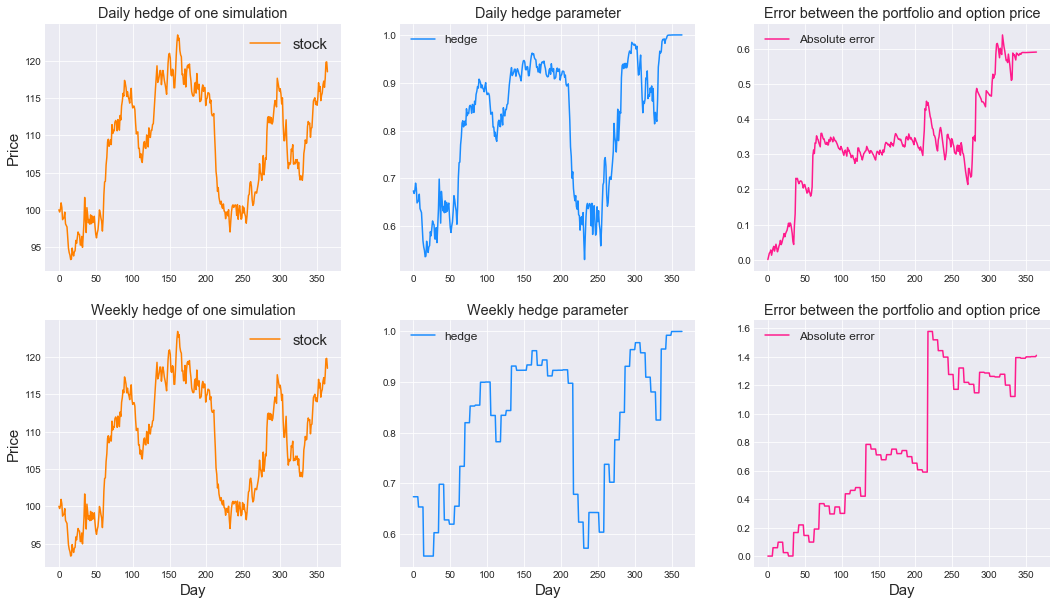

In [416]:
plt.figure(figsize=(18,10))
plt.style.use("seaborn-darkgrid")
price=simulation(100,99)
optionpricelist,hedgelist,borrowlist,portlist,errorlist=pri_hedge_change(price, 99,1)
optionpricelist_week,hedgelist_week,borrowlist_week,portlist_week,errorlist_week=pri_hedge_change(price, 99,7)
print('daily',hedgelist[-2]*price[-1]-max(price[-1]-k,0)-(borrowlist[-2]*np.exp(0.06 * 1/365)))
print('weekly',hedgelist_week[-2]*price[-1]-max(price[-1]-k,0)-(borrowlist_week[-2]*np.exp(0.06 * 1/365)))
plt.subplot(2,3,1)
plt.plot(price, label='stock',color='#ff8000')
plt.ylabel('Price',size=15)
plt.title('Daily hedge of one simulation')
plt.legend(fontsize=15)
plt.subplot(2,3,2)
plt.plot(hedgelist, label='hedge',color='#1a8cff')

plt.title('Daily hedge parameter')
plt.legend(fontsize=12)
plt.subplot(2,3,3)
plt.plot(abs(portlist-optionpricelist), label='Absolute error',color='#ff1a8c')
plt.title('Error between the portfolio and option price')
plt.legend(fontsize=12)
plt.subplot(2,3,4)
plt.plot(price, label='stock',color='#ff8000')
plt.xlabel('Day',size=15)
plt.ylabel('Price',size=15)
plt.title('Weekly hedge of one simulation')
plt.legend(fontsize=15)
plt.subplot(2,3,5)
plt.plot(hedgelist_week, label='hedge',color='#1a8cff')
plt.xlabel('Day',size=15)
plt.title('Weekly hedge parameter')
plt.xlabel('Day',size=15)
plt.legend(fontsize=12)
plt.subplot(2,3,6)
plt.plot(abs(portlist_week-optionpricelist_week), label='Absolute error',color='#ff1a8c')
plt.title('Error between the portfolio and option price')
plt.xlabel('Day',size=15)
plt.legend(fontsize=12)
plt.savefig('Single_simulation_compare.jpg',dpi=200,bbox_inches='tight')
plt.show()

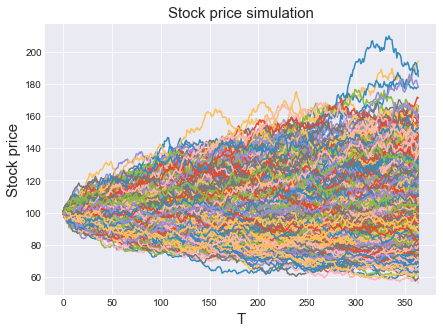

In [233]:
plt.figure(figsize=(7,5))
for i in range(1000):
    plt.plot(simulation(100,99))
plt.title('Stock price simulation',size=15)
plt.xlabel('T',size=15)
plt.ylabel('Stock price',size=15)
plt.savefig('Stock_price_simulation.jpg',dpi=200)

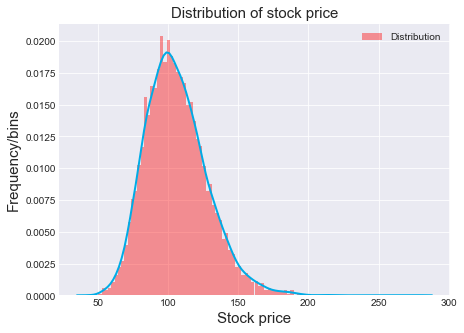

In [254]:
import seaborn as sns 
import matplotlib as mpl 
plt.figure(figsize=(7,5))
sns.set_palette("hls") 
mpl.rc("figure", figsize=(6,4)) 
sns.distplot(S,bins=100,kde_kws={"color":"#00ace6", "lw":2 }, hist_kws={ "color": "#ff0000" },label='Distribution')
plt.legend()
plt.xlabel('Stock price',size=15)
plt.ylabel('Frequency/bins',size=15)
plt.title('Distribution of stock price',size=15)
plt.savefig('distribution_Stock_price_simulation.jpg',dpi=200)
plt.show()

# daily

In [210]:
final=[]
for i in range(1000):
    price=simulation(100,99)
    optionpricelist,hedgelist,borrowlist,portlist,errorlist=pri_hedge_change(price, 99,1)
    final.append(hedgelist[-2]*price[-1]-max(price[-1]-k,0)-(borrowlist[-2]*np.exp(0.06 * 1/365)))


# week

In [211]:
final_week=[]
for i in range(1000):
    price=simulation(100,99)
    optionpricelist,hedgelist,borrowlist,portlist,errorlist=pri_hedge_change(price, 99,7)
    final_week.append(hedgelist[-2]*price[-1]-max(price[-1]-k,0)-(borrowlist[-2]*np.exp(0.06 * 1/365)))

# Sigma match day+week

0.03240334610925891 0.11936793906949743


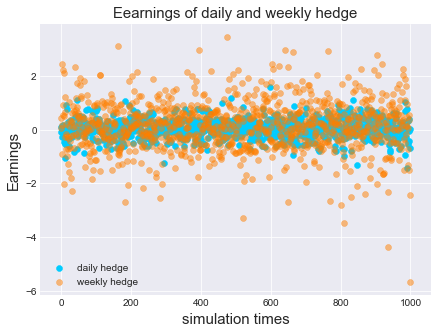

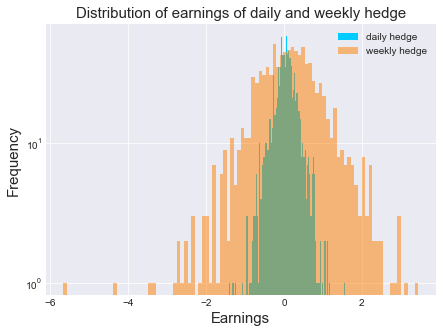

In [267]:
plt.figure(figsize=(7,5))
print(np.mean(final),np.mean(final_week))
plt.scatter(np.arange(0,1000,1),final,label='daily hedge',color='#00ccff')
plt.scatter(np.arange(0,1000,1),final_week,alpha=0.5,label='weekly hedge',color='#ff8000')
plt.ylabel('Earnings',size=15)
plt.xlabel('simulation times',size=15)
plt.title('Eearnings of daily and weekly hedge',size=15)
plt.legend()
plt.savefig('Daily and weekly hedge.jpg',dpi=200)
plt.show()
plt.figure(figsize=(7,5))
plt.hist(final,bins=100,label='daily hedge',color='#00ccff')[2]
plt.hist(final_week,bins=100,alpha=0.5,label='weekly hedge',color='#ff8000')[2]
plt.xlabel('Earnings',size=15)
plt.ylabel('Frequency',size=15)
plt.title('Distribution of earnings of daily and weekly hedge',size=15)
plt.yscale('log')
plt.legend()
plt.savefig('Distribution of earnings of daily and weekly hedge.jpg',dpi=200)

# Sigma unmatch

In [292]:
k=99
final_1=[]
for i in range(1000):
    price=simulation(100,99,sigma=0.7)
    optionpricelist,hedgelist,borrowlist,portlist,errorlist=pri_hedge_change(price, 99,1)
    final_1.append(hedgelist[-2]*price[-1]-max(price[-1]-k,0)-(borrowlist[-2]*np.exp(0.06 * 1/365)))

In [293]:
k=99
for i in range(1000):
    price=simulation(100,99,sigma=0.7)
    optionpricelist,hedgelist,borrowlist,portlist,errorlist=pri_hedge_change(price, 99,7)
    final_1_week.append(hedgelist[-2]*price[-1]-max(price[-1]-k,0)-(borrowlist[-2]*np.exp(0.06 * 1/365)))

-19.497404947474195 -19.2878958682689


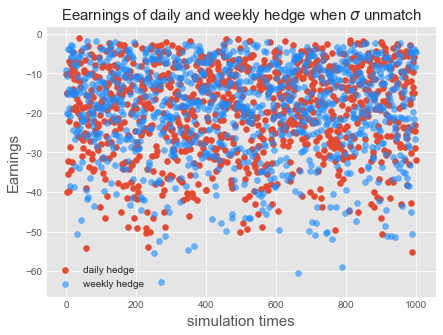

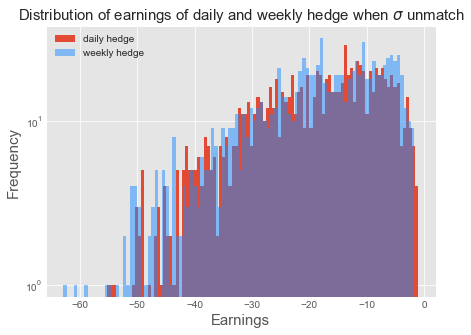

In [298]:
print(np.mean(final_1),np.mean(final_1_week))
plt.figure(figsize=(7,5))
plt.scatter(np.arange(0,1000,1),final_1,label='daily hedge')
plt.scatter(np.arange(0,1000,1),final_1_week,alpha=0.6,label='weekly hedge',color='#1a8cff')
plt.ylabel('Earnings',size=15)
plt.xlabel('simulation times',size=15)
plt.title('Eearnings of daily and weekly hedge when $\sigma$ unmatch',size=15)
plt.legend()
plt.savefig('Daily and weekly hedge when sigma unmatch.jpg',dpi=200)
plt.show()
plt.figure(figsize=(7,5))
plt.hist(final_1,bins=100,label='daily hedge')[2]
plt.hist(final_1_week,bins=100,alpha=0.5,label='weekly hedge',color='#1a8cff')[2]
plt.xlabel('Earnings',size=15)
plt.ylabel('Frequency',size=15)
plt.title('Distribution of earnings of daily and weekly hedge when $\sigma$ unmatch',size=15)
plt.yscale('log')
plt.legend()
plt.savefig('Distribution of earnings of daily and weekly hedge when sigma unmatch.jpg',dpi=200)

# 3d plot different sigma match +unmatch

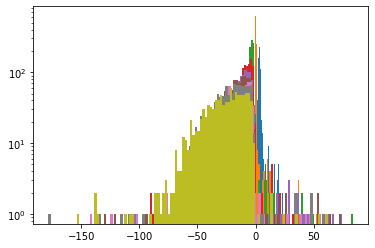

In [54]:
sigmalist=np.arange(0.1,1,0.1)
xlist=[]
ylist=[]
unmatchsigmalist=[]
for i in sigmalist:
    final_1=[]
    for h in range(1000):
        price=simulation(100,99,sigma=i)
        optionpricelist,hedgelist,borrowlist,portlist,errorlist=pri_hedge_change(price, 99,1)
        final_1.append(hedgelist[-2]*price[-1]-max(price[-1]-k,0)-borrowlist[-1])
    unmatchsigmalist.append(np.mean(final_1))
    y,x,z =plt.hist(final_1,bins=100)
    xlist.append(x[:-1])
    ylist.append(y)
plt.yscale('log')       

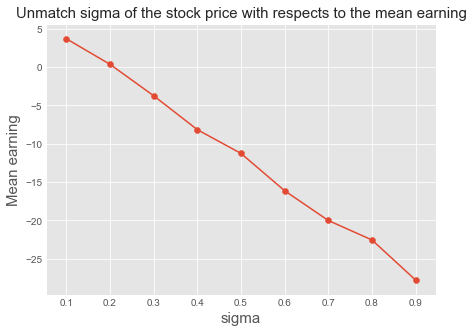

In [300]:
plt.figure(figsize=(7,5))
plt.plot(sigmalist,unmatchsigmalist)
plt.scatter(sigmalist,unmatchsigmalist)
plt.title('Unmatch sigma of the stock price with respects to the mean earning',size=15)
plt.xlabel('sigma',size=15)
plt.ylabel('Mean earning',size=15)
plt.savefig('Unmatch sigma of the stock price with respects to the mean earning.jpg',dpi=200)

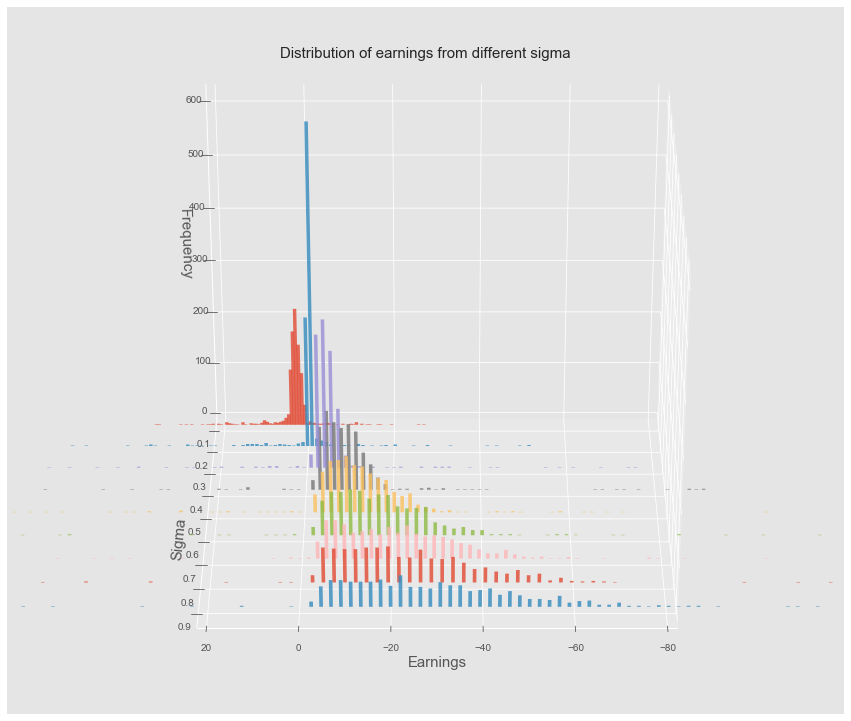

In [286]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(15,13))
ax = fig.add_subplot(111, projection='3d')
for h, z in zip(np.arange(0,len(xlist),1), np.arange(0.1,1,0.1)):
    xs = xlist[h]
    ys = ylist[h]

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
#     cs = [c] * len(xs)
#     cs[0] = 'c'
    ax.bar(xs, ys, zs=z, zdir='y', alpha=0.8,label='$sigma$='+str(sigmalist[h]))
ax.set_title('Distribution of earnings from different sigma',size=15)
ax.set_xlabel('Earnings',size=15)
ax.set_ylabel('Sigma',size=15)
ax.set_zlabel('Frequency',size=15)
ax.set_xlim(-80,20)
ax.view_init(30, 90)
plt.savefig('3d_Distribution of earning from different sigma.jpg',dpi=200)
plt.show()